**Installing the Dataset**

In [ ]:
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

**Mounting to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_dir = "/content/drive/MyDrive/tiny-imagenet-200"

# Download and extract only if not already in Drive
if not os.path.exists(dataset_dir):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O /content/tiny-imagenet-200.zip
    !unzip -q /content/tiny-imagenet-200.zip -d /content/
    # Move to Google Drive for future reuse
    !mv /content/tiny-imagenet-200 /content/drive/MyDrive/
else:
    print("Dataset already exists in Drive.")


Dataset already exists in Drive.


**Preprocessing of the Images in Dataset**

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFilter, ImageEnhance

# Custom preprocessing function for Tiny ImageNet images
def enhance_and_resize(img):
    img = img.resize((224, 224), resample=Image.BICUBIC)
    img = img.filter(ImageFilter.SHARPEN)
    return img

def enhance_contrast(img):
    img = ImageEnhance.Contrast(img).enhance(1.5)
    img = ImageEnhance.Sharpness(img).enhance(1.5)
    return img

def custom_preprocessing(img):
    img = enhance_and_resize(img)
    img = enhance_contrast(img)
    return img

# Wrapper to integrate into torchvision transforms
class PreprocessAndToTensor:
    def __init__(self):
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __call__(self, img):
        img = custom_preprocessing(img)
        return self.to_tensor(img)

# Load Tiny ImageNet with custom preprocessing
dataset_path = "/content/drive/MyDrive/tiny-imagenet-200/train"
transform = PreprocessAndToTensor()

dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Test batch
sample_imgs, sample_labels = next(iter(dataloader))
sample_imgs.shape, sample_labels[:5]


(torch.Size([16, 3, 224, 224]), tensor([170,   4, 102, 126, 102]))

**Displaying random images from Dataset after preprocessing**

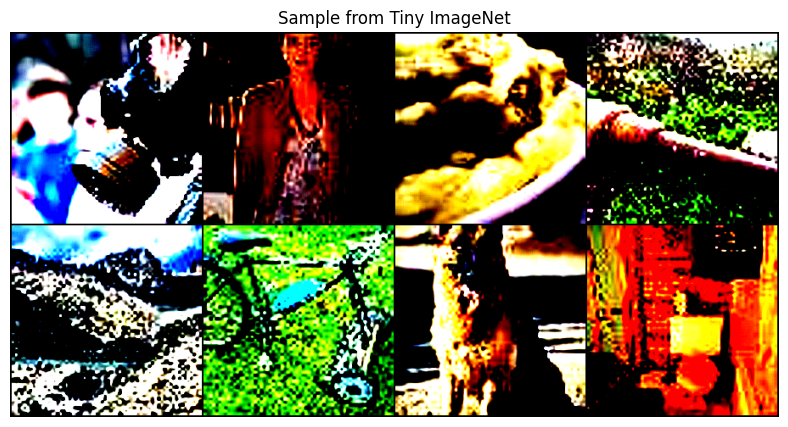

Batch shape: torch.Size([16, 3, 224, 224])
Labels: tensor([106,  85, 182,  84, 194, 114,  28, 131,  16,   9,  78, 183, 186, 140,
        101,  86])


In [ ]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(dataloader))

# Display 8 images
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.title("Sample from Tiny ImageNet")
plt.show()

print("Batch shape:", images.shape)
print("Labels:", labels)


**Loading the pretrained model & adjusting for input**

In [ ]:
import torch
import torchvision.models as models

# Load pretrained Resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.eval().to(device)

# Adjust preprocessing for ResNet (224 input)
transform_resnet = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # same mean/std as Inception
        std=[0.229, 0.224, 0.225]
    )
])



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from torchvision import transforms

inception_preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])


**Querying the Model for Predictions**

This function queries the target model (model) to get predictions for a given preprocessed image tensor.

If return_probs=True, it returns softmax probabilities over all classes.

If return_probs=False, it returns the top-k predicted class indices.
This is used to interact with the model during the moderation and evaluation processes

In [ ]:
import torch.nn.functional as F

def query_model(image_tensor, topk=5, return_probs=True):
    """
    image_tensor: shape (1, 3, 299, 299), already preprocessed
    return_probs=True → return softmax probabilities (QL, PI)
    return_probs=False → return top-k labels (LO)
    """
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        logits = model(image_tensor)
        if return_probs:
            probs = F.softmax(logits, dim=1)
            return probs.cpu().squeeze()
        else:
            topk_indices = torch.topk(logits, k=topk, dim=1).indices.cpu().squeeze()
            return topk_indices


**Loading a Custom Image and Querying the Model**

This block loads a custom input image (specified by img_path), preprocesses it for the Inception model, and queries the model:

It retrieves both the top-5 predicted class labels and their associated probabilities.

It also visualizes the input image using matplotlib for easy reference.

Image Path: /content/flamingo.jpg
Top-5 predicted labels (Inception): [130, 128, 127, 134, 144]
Probabilities (Top-5): [0.9602670669555664, 0.008020484820008278, 0.005872231442481279, 0.0035085584968328476, 0.0033215750008821487]


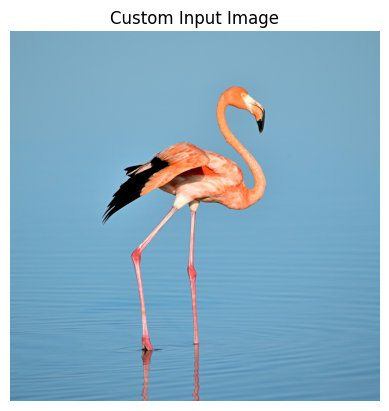

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# === Change this path to your desired image path ===
img_path = '/content/flamingo.jpg'  # e.g., './sample.jpg'

# Load and preprocess the image
image = Image.open(img_path).convert('RGB')
input_tensor = inception_preprocess(image).unsqueeze(0)  # (1, 3, 299, 299)

# Query the model
probs = query_model(input_tensor, return_probs=True)
top_labels = query_model(input_tensor, return_probs=False)

# Show output
print("Image Path:", img_path)
print("Top-5 predicted labels (Inception):", top_labels.tolist())
print("Probabilities (Top-5):", probs[top_labels].tolist())

# Visualize
plt.imshow(image)
plt.title("Custom Input Image")
plt.axis('off')
plt.show()


**Mapping Class Indices to Human-Readable Labels**


This block accesses the class-to-index mapping (class_to_idx) from the dataset and inverts it to build an index-to-label dictionary.
It then prints all the class labels sorted by their index to make model outputs easier to interpret.

In [ ]:
# Access label-to-index mapping
label_to_idx = dataset.class_to_idx

# Invert it to index-to-label for readability
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Display all labels sorted by index
print("Total classes:", len(idx_to_label))
for idx in sorted(idx_to_label):
    print(f"Label {idx}: {idx_to_label[idx]}")


Total classes: 200
Label 0: n01443537
Label 1: n01629819
Label 2: n01641577
Label 3: n01644900
Label 4: n01698640
Label 5: n01742172
Label 6: n01768244
Label 7: n01770393
Label 8: n01774384
Label 9: n01774750
Label 10: n01784675
Label 11: n01855672
Label 12: n01882714
Label 13: n01910747
Label 14: n01917289
Label 15: n01944390
Label 16: n01945685
Label 17: n01950731
Label 18: n01983481
Label 19: n01984695
Label 20: n02002724
Label 21: n02056570
Label 22: n02058221
Label 23: n02074367
Label 24: n02085620
Label 25: n02094433
Label 26: n02099601
Label 27: n02099712
Label 28: n02106662
Label 29: n02113799
Label 30: n02123045
Label 31: n02123394
Label 32: n02124075
Label 33: n02125311
Label 34: n02129165
Label 35: n02132136
Label 36: n02165456
Label 37: n02190166
Label 38: n02206856
Label 39: n02226429
Label 40: n02231487
Label 41: n02233338
Label 42: n02236044
Label 43: n02268443
Label 44: n02279972
Label 45: n02281406
Label 46: n02321529
Label 47: n02364673
Label 48: n02395406
Label 49: n

**Utility Functions for Adversarial Example Handling and Label Interpretation**

This section defines several helper functions:

clip: Ensures adversarial images stay within an epsilon-ball (L∞ norm) of the original image.

rank: Returns the ranking (0 = top1) of a true label within the model’s output probabilities.

topk_labels: Retrieves the top-k predicted class indices from a probability distribution.

label_to_name: Converts a class index to a human-readable ImageNet label by downloading label names if necessary.

A quick demonstration is also shown where the rank, top-5 labels, and the readable label name are printed for a sample prediction.

In [ ]:
def clip(x_adv, x_orig, epsilon):
    """
    Clips the adversarial example to be within epsilon of the original under L∞ norm.
    Args:
        x_adv (Tensor): adversarial image (B, C, H, W)
        x_orig (Tensor): original image (B, C, H, W)
        epsilon (float): max allowed perturbation
    Returns:
        Tensor: clipped image
    """
    return torch.clamp(x_adv, x_orig - epsilon, x_orig + epsilon).clamp(0, 1)

def rank(y, probs):
    """
    Returns the rank (0-based) of the true label y in the probability distribution.
    Args:
        y (int): target label index
        probs (Tensor): probability distribution (num_classes,)
    Returns:
        int: rank of y (0 = top1)
    """
    sorted_indices = torch.argsort(probs, descending=True)
    return (sorted_indices == y).nonzero(as_tuple=True)[0].item()

def topk_labels(probs, k=5):
    """
    Returns the indices of the top-k probabilities.
    Args:
        probs (Tensor): probability distribution (num_classes,)
        k (int): number of top classes
    Returns:
        Tensor: indices of top-k predictions
    """
    return torch.topk(probs, k).indices

import json
import requests

def label_to_name(idx):
    """
    Converts ImageNet class index (0–999) to human-readable label.
    Requires downloading the index-to-name mapping if not already present.
    """
    if not hasattr(label_to_name, "idx_to_label"):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        label_to_name.idx_to_label = response.text.strip().split("\n")

    return label_to_name.idx_to_label[idx]


In [ ]:
probs = query_model(input_tensor, return_probs=True)
target = 109  # say, flamingo
print("Rank of label:", rank(target, probs))
print("Top-5 labels:", topk_labels(probs, 5).tolist())
print("Label name:", label_to_name(target))


Rank of label: 800
Top-5 labels: [130, 128, 127, 134, 144]
Label name: brain coral


**NES-based Gradient Estimation for Black-box Attacks**


This section implements Natural Evolution Strategies (NES) to estimate gradients without direct access to model internals:

nes_gradient_estimate: Approximates the gradient of an objective function (like target class probability) using Gaussian perturbations and antithetic sampling to reduce variance.

ql_objective_fn: Defines the query-loss (QL) objective, which simply returns the model’s predicted probability for a given target class.



In [ ]:
def nes_gradient_estimate(x, objective_fn, sigma=0.001, n_samples=50):
    """
    Estimate the gradient of an objective function using NES.

    Args:
        x (Tensor): current adversarial example (1, C, H, W)
        objective_fn (callable): function that takes an image tensor and returns a scalar (probability or proxy score)
        sigma (float): standard deviation of Gaussian noise
        n_samples (int): number of perturbation directions (half will be negated for antithetic sampling)

    Returns:
        Tensor: estimated gradient (same shape as x)
    """
    grads = torch.zeros_like(x)
    for _ in range(n_samples // 2):  # use antithetic sampling
        u = torch.randn_like(x)
        f_pos = objective_fn((x + sigma * u).clamp(0, 1))
        f_neg = objective_fn((x - sigma * u).clamp(0, 1))
        grads += (f_pos - f_neg) * u

    grad_estimate = grads / (sigma * n_samples)
    return grad_estimate


def ql_objective_fn(x):
    """Returns probability of the target class"""
    probs = query_model(x, return_probs=True)
    return probs[target_label].item()



**Estimating and Visualizing NES Gradients on a Custom Image**

This block:

Loads and preprocesses a custom input image.

Sets a target label (e.g., flamingo = 109) for gradient estimation.

Estimates the NES gradient with respect to the query-loss (target class probability).

Prints basic statistics (mean and standard deviation) of the estimated gradient.

Visualizes the gradient map by normalizing it and plotting it as an image for intuitive understanding.

In [ ]:
from PIL import Image

# === Change this to your custom image path ===
img_path = '/content/flamingo.jpg'  # e.g., './sample.jpg'

# Load and preprocess image
image = Image.open(img_path).convert('RGB')
x_orig = inception_preprocess(image).unsqueeze(0).to(device)  # (1, 3, 299, 299)

# Set a dummy target label for testing
target_label = 109

# Estimate gradient
grad = nes_gradient_estimate(x_orig, objective_fn=ql_objective_fn, sigma=0.001, n_samples=50)

# Print stats
print("Estimated gradient shape:", grad.shape)
print("Gradient stats → mean:", grad.mean().item(), " | std:", grad.std().item())


Estimated gradient shape: torch.Size([1, 3, 299, 299])
Gradient stats → mean: 4.309388401679826e-09  | std: 3.376464155735448e-05


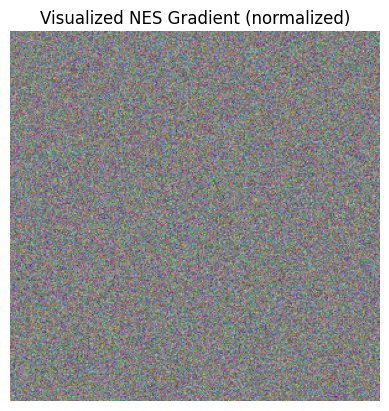

In [ ]:
import matplotlib.pyplot as plt

# Normalize for visualization
grad_cpu = grad.squeeze().detach().cpu()
grad_vis = grad_cpu.permute(1, 2, 0).numpy()
grad_vis = (grad_vis - grad_vis.min()) / (grad_vis.max() - grad_vis.min())

plt.imshow(grad_vis)
plt.title("Visualized NES Gradient (normalized)")
plt.axis('off')
plt.show()


**Performing a Query-Limited Black-Box Attack using NES**

This section implements a query-limited adversarial attack:

query_limited_attack:

Uses NES to estimate the gradient of the target class probability.

Applies a PGD-style update constrained within an L∞ ball (defined by epsilon).

Repeats until either the target class appears in top-5 predictions or the maximum query budget is reached.

After running the attack:

Prints whether the attack succeeded and the number of queries used.

Visualizes a side-by-side comparison of the original and the adversarial images.

In [ ]:
def query_limited_attack(
    x_orig, target_label, epsilon, sigma, step_size, n_samples, max_queries, query_model_fn
):
    """
    Query-limited attack using NES + PGD.

    Args:
        x_orig (Tensor): original image (1, C, H, W)
        target_label (int): adversarial target class
        epsilon (float): max L∞ norm
        sigma (float): NES noise std
        step_size (float): PGD step size
        n_samples (int): number of NES samples per gradient step
        max_queries (int): query budget
        query_model_fn (function): returns softmax probabilities for a given image

    Returns:
        x_adv (Tensor): final adversarial example
        success (bool): whether target was achieved
        num_queries (int): total queries used
    """
    x_adv = x_orig.clone().detach()
    num_queries = 0
    success = False

    while num_queries < max_queries:
        # Compute NES gradient
        def objective_fn(x):
            probs = query_model_fn(x, return_probs=True)
            return probs[target_label].item()

        grad = nes_gradient_estimate(x_adv, objective_fn, sigma=sigma, n_samples=n_samples)
        num_queries += n_samples  # NES queries

        # PGD update
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon)

        # Check success
        probs = query_model_fn(x_adv, return_probs=True)
        num_queries += 1

        top5 = torch.topk(probs, k=5).indices.tolist()
        if target_label in top5:
            success = True
            break
        # pred_label = torch.argmax(probs).item()

        # if pred_label == target_label:
        #     success = True
        #     break

    return x_adv, success, num_queries


In [ ]:
x_orig = inception_preprocess(image).unsqueeze(0).to(device)
target_label = 129  # Choose adversarial target

x_adv, success, used_queries = query_limited_attack(
    x_orig,
    target_label=target_label,
    epsilon=0.3,
    sigma=0.06,
    step_size=0.1,
    n_samples=30,
    max_queries=1000000,
    query_model_fn=query_model  # This is your query function
)

print(f"Attack {'succeeded' if success else 'failed'} in {used_queries} queries.")


Attack succeeded in 31 queries.


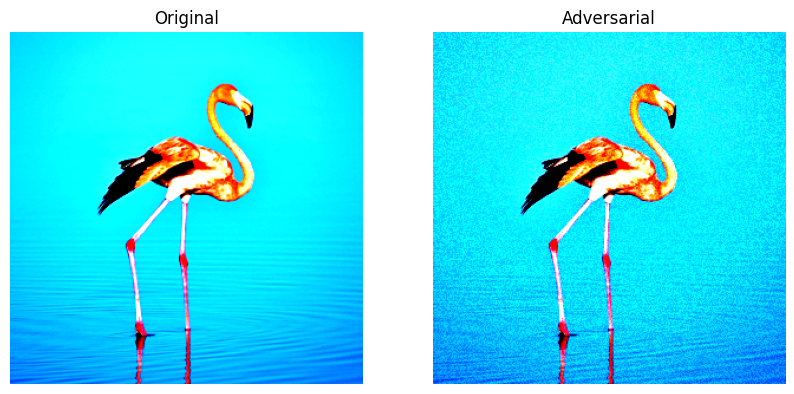

In [ ]:
import matplotlib.pyplot as plt

def show_comparison(x1, x2, labels=["Original", "Adversarial"]):
    x1_img = x1.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    x2_img = x2.squeeze().permute(1, 2, 0).detach().cpu().numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x1_img)
    axs[0].set_title(labels[0])
    axs[0].axis('off')
    axs[1].imshow(x2_img)
    axs[1].set_title(labels[1])
    axs[1].axis('off')
    plt.show()

show_comparison(x_orig, x_adv)


In [ ]:
def clip(x_adv, x_orig, epsilon):
    """
    Clips the adversarial example to be within epsilon of the original under L∞ norm.
    Args:
        x_adv (Tensor): adversarial image (B, C, H, W)
        x_orig (Tensor): original image (B, C, H, W)
        epsilon (float): max allowed perturbation
    Returns:
        Tensor: clipped image
    """
    return torch.clamp(x_adv, x_orig - epsilon, x_orig + epsilon).clamp(0, 1)

def rank(y, probs):
    """
    Returns the rank (0-based) of the true label y in the probability distribution.
    Args:
        y (int): target label index
        probs (Tensor): probability distribution (num_classes,)
    Returns:
        int: rank of y (0 = top1)
    """
    sorted_indices = torch.argsort(probs, descending=True)
    return (sorted_indices == y).nonzero(as_tuple=True)[0].item()

def topk_labels(probs, k=5):
    """
    Returns the indices of the top-k probabilities.
    Args:
        probs (Tensor): probability distribution (num_classes,)
        k (int): number of top classes
    Returns:
        Tensor: indices of top-k predictions
    """
    return torch.topk(probs, k).indices

import json
import requests

def label_to_name(idx):
    """
    Converts ImageNet class index (0–999) to human-readable label.
    Requires downloading the index-to-name mapping if not already present.
    """
    if not hasattr(label_to_name, "idx_to_label"):
        url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        response = requests.get(url)
        label_to_name.idx_to_label = response.text.strip().split("\n")

    return label_to_name.idx_to_label[idx]


**Partial-Information Attack Using Top-k Predictions Only**

This block implements a partial-information black-box attack that assumes access only to the model’s top-k class predictions (no probability scores):

Stage 1 — Epsilon Shrinking:

Gradually shrinks the perturbation (epsilon) by taking small steps toward the original image, while ensuring the target class stays in the top-k predictions.

Stage 2 — NES Gradient Ascent:

Once shrinkage is done, uses a NES-based proxy objective that rewards the target class being higher ranked within top-k predictions.

Updates the adversarial image while staying within the final small epsilon constraint.

Returns the adversarial image, attack success flag, and total number of queries used.



In [ ]:
def partial_info_attack(
    x_orig, target_label,
    epsilon_init=2.0, epsilon_final=0.01, decay_rate=0.95,
    shrink_steps=300,
    sigma=0.005, step_size=0.01, n_samples=100, max_queries=5000,
    query_model_fn=None, topk=3
):
    """
    Partial-Information attack with access only to top-k predictions.
    Works with just a target class (no target image required).

    Args:
        x_orig: original image tensor (1, C, H, W)
        target_label: target class index
        ...

    Returns:
        x_adv: final adversarial example
        success: whether target_label is in top-k
        num_queries: total queries used
    """
    # Initialize x_adv by adding random noise to x_orig
    x_adv = x_orig.clone().detach() + torch.randn_like(x_orig) * epsilon_init
    x_adv = torch.clamp(x_adv, 0, 1)
    epsilon = epsilon_init
    num_queries = 0

    # === Stage 1: Epsilon Shrinking ===
    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            print(f"Target dropped out of top-{topk} during shrinking (step {i})")
            break

    # === Stage 2: NES-based gradient ascent ===
    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        if target_label in preds:
            return topk - preds.index(target_label)
        else:
            return 0

    for _ in range(20):
        grad = nes_gradient_estimate(x_adv, proxy_objective, sigma=sigma, n_samples=n_samples)
        num_queries += n_samples
        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1
        if target_label in topk_preds:
            success = True
        else:
            success = False
            break

    return x_adv, success, num_queries


**Doing the same preprocessing part for a different image to perform the attack**

In [ ]:
import torch
import torchvision.models as models

# Load pretrained Resnet
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.eval().to(device)

# Adjust preprocessing for ResNet (224 input)
transform_resnet = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])



In [ ]:
from torchvision import transforms

inception_preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])


Image Path: /content/vulture.jpg
Top-5 predicted labels (Inception): [23, 21, 22, 24, 89]
Probabilities (Top-5): [0.5622038841247559, 0.21254262328147888, 0.06997757405042648, 0.022326583042740822, 0.018762338906526566]


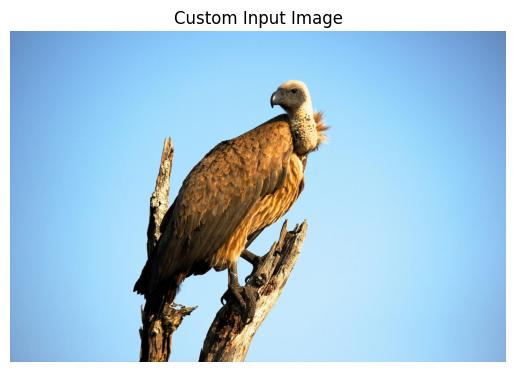

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# === Change this path to your desired image path ===
img_path = '/content/vulture.jpg'  # e.g., './sample.jpg'

# Load and preprocess the image
image = Image.open(img_path).convert('RGB')
input_tensor = inception_preprocess(image).unsqueeze(0)  # (1, 3, 299, 299)

# Query the model
probs = query_model(input_tensor, return_probs=True)
top_labels = query_model(input_tensor, return_probs=False)

# Show output
print("Image Path:", img_path)
print("Top-5 predicted labels (Inception):", top_labels.tolist())
print("Probabilities (Top-5):", probs[top_labels].tolist())

# Visualize
plt.imshow(image)
plt.title("Custom Input Image")
plt.axis('off')
plt.show()


**Running the Partial-Information Attack on a Target Image**

This block executes the partial-information attack:

Reuses a preprocessed victim image (x_orig).

Sets the adversarial target label manually (e.g., 129).

Runs the partial-information attack using the previously defined partial_info_attack function.

After the attack, prints whether the attack succeeded and the number of queries used.

In [ ]:
import torch



# === Set target label manually ===
target_label = 129  #  Change this to the class you want to target

# === Run Partial Information Attack ===
x_adv, success, queries = partial_info_attack(
    x_orig=x_orig,                # Preprocessed victim image
    target_label=target_label,    #  Just the label (no image)
    epsilon_init=2.0,
    epsilon_final=0.01,
    sigma=0.005,
    step_size=0.005,
    n_samples=100,
    max_queries=10000,
    query_model_fn=query_model,
    topk=3
)

print(f"Success: {success}, Queries: {queries}")


Target dropped out of top-3 during shrinking (step 0)
Success: True, Queries: 2021


****

**Label-Only Attack Using Top-k Predictions**

This function implements a label-only black-box adversarial attack that works by accessing only the top-k predicted labels from the model. The goal is to manipulate a target image to make the model classify it as the target_label.

Stage 1: Epsilon Shrinking
Objective: Gradually reduce the perturbation (epsilon) by iteratively adjusting the image while keeping the target_label in the top-k predictions.

Process:

For a fixed number of steps (shrink_steps), the attack queries the model for the top-k predictions of the adversarial image (x_adv).

If the target_label remains in the top-k predictions, the image is updated in the direction of the difference between x_adv and the original image (x_orig), ensuring the perturbation stays within the bounds defined by epsilon.

After each step, epsilon is decayed by the decay_rate, but it never goes below epsilon_final.

If at any point the target_label is dropped from the top-k predictions, the shrinking phase ends.

Stage 2: Proxy Optimization (Based on Rank)
Objective: Once the perturbation has been sufficiently reduced, the attack switches to using a rank-based proxy objective to further optimize the image.

Process:

The proxy objective rewards the adversarial image by ranking the target_label higher in the model's top-k predictions. This is done using Natural Evolution Strategy (NES) for gradient-free optimization.

In each step, the gradient is estimated by sampling multiple adversarial images and evaluating how the target_label ranks within the top-k predictions.

The image is updated based on the gradient direction, and the perturbation is kept within the bounds of epsilon_final.

The process runs for a fixed number of 20 steps.

Return Values:
x_adv: The adversarially modified image that should ideally be classified as the target_label by the model.

success: A boolean indicating whether the attack was successful (i.e., if the model predicted the target_label for x_adv).

num_queries: The total number of queries made to the model during the attack.

In [ ]:
def label_only_attack(
    x_orig, x_target, target_label,
    epsilon_init=1.0, epsilon_final=0.05, decay_rate=0.98, shrink_steps=100,
    sigma=0.005, step_size=0.01, n_samples=50, max_queries=2000,
    query_model_fn=query_model, topk=5
):
    """
    Label-only black-box adversarial attack.
    Assumes only top-k class labels are visible.
    """
    x_adv = x_target.clone().detach()
    epsilon = epsilon_init
    num_queries = 0

    # === Phase 1: Shrinking epsilon (just like PI)
    for i in range(shrink_steps):
        topk_preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1

        if target_label in topk_preds:
            direction = torch.sign(x_adv - x_orig)
            x_adv = x_adv - step_size * direction
            x_adv = clip(x_adv, x_orig, epsilon)
            epsilon = max(epsilon * decay_rate, epsilon_final)
        else:
            print(f"Target dropped from top-{topk} during shrinking.")
            break

    # === Phase 2: Proxy optimization (based on rank)
    def proxy_objective(x):
        preds = query_model_fn(x, return_probs=False).tolist()
        if target_label in preds:
            rank_score = topk - preds.index(target_label)
        else:
            rank_score = 0
        return rank_score  # higher is better

    for _ in range(20):  # fixed PGD steps
        grad = nes_gradient_estimate(x_adv, proxy_objective, sigma=sigma, n_samples=n_samples)
        num_queries += n_samples

        x_adv = x_adv + step_size * torch.sign(grad)
        x_adv = clip(x_adv, x_orig, epsilon_final)

        preds = query_model_fn(x_adv, return_probs=False).tolist()
        num_queries += 1
        if target_label in preds:
            success = True
        else:
            success = False
            break

    return x_adv, success, num_queries


**Ikkada random ga badhalu target set chey see in above code daan tarvatha malli preprocesing cell raayi adi size malli match avadhu nen malli preprocess chesa adi okasari choodu ledu nee degara direct code unde add chey**

In [ ]:
# Choose a target image that the model predicts as target_label
x_target, target_label = dataset[random.randint(0, len(dataset)-1)]
x_target = x_target.unsqueeze(0).to(device)

# Choose a victim image to morph
x_orig, true_label = dataset[random.randint(0, len(dataset)-1)]
x_orig = x_orig.unsqueeze(0).to(device)

# Run Label-Only attack
x_adv, success, queries = label_only_attack(
    x_orig, x_target, target_label,
    epsilon_init=1.0,
    epsilon_final=0.05,
    sigma=0.005,
    step_size=0.01,
    n_samples=50,
    max_queries=2000,
    query_model_fn=query_model,
    topk=5
)

print(f"Label-Only Attack Success: {success}, Queries: {queries}")


Target dropped from top-5 during shrinking.
Label-Only Attack Success: False, Queries: 52
